In [1]:
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import crystalball
from scipy.optimize import curve_fit,Bounds
from scipy.integrate import simps
import zfit_physics as zphysics
import zfit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import mplhep
import uncertainties 
from uncertainties import ufloat
import tensorflow as tf

plt.style.use('belle2')
#%jsroot on


#%run /afs/desy.de/user/j/jipatel/MT/MC_fit/Files_After_Acceptance/Signal_Background_thesis_final/Function.ipynb

2024-09-05 19:52:33.292253: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-05 19:52:40.582589: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-05 19:52:40.591513: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-05 19:52:43.127655: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warnin

In [2]:
file_bkg_ele_B0pip="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/background/B0eepip4Streams.root"
file_signal_ele_B0pip="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/signal/B0eepip4Streams.root"


file_bkg_mu_B0pip="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/background/B0mumupip4Streams.root"
file_signal_mu_B0pip="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/signal/B0mumupip4Streams.root"


In [3]:
file_bkg_ele_Bppip="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/background/Bpeepip4Streams.root"
file_signal_ele_Bppip="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/signal/Bpeepip4Streams.root"


file_bkg_mu_Bppip="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/background/Bpmumupip4Streams.root"
file_signal_mu_Bppip="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/signal/Bpmumupip4Streams.root"


In [4]:
file_bkg_ele_Bppi0="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/background/Bpeepi04Streams.root"
file_signal_ele_Bppi0="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/signal/Bpeepi04Streams.root"


file_bkg_mu_Bppi0="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/background/Bpmumupi04Streams.root"
file_signal_mu_Bppi0="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/signal/Bpmumupi04Streams.root"


In [5]:
class trimVars():
    @staticmethod
    def trimCosTheta_L(df, Btree, pi, ll, q2):
        if int(Btree) == 511:
            if q2 == 1:
                df = df.query('abs(cosTheta_L) < 0.75')
            if q2 == 4:
                df = df.query('abs(cosTheta_L) < 0.95')
        
        if int(Btree) == 521:
            if pi == 'pip':
                if q2 == 1:
                    df = df.query('abs(cosTheta_L) < 0.75')
                elif q2 == 4:
                    df = df.query('abs(cosTheta_L) < 0.95')
            if pi =='pi0':
                if q2 == 1:
                    df = df.query('abs(cosTheta_L) < 0.75')
                elif q2 != 4:
                    df = df.query('abs(cosTheta_L) < 0.9')
        return df
    
    @staticmethod
    def trimCosTheta_K(df, Btree, pi, ll, q2):
        if int(Btree) == 511:
            if q2 == 1:
                df = df.query('cosTheta_K > -0.9')
            elif q2 != 4:
                df = df.query('cosTheta_K > -0.9')
            else:
                df = df.query('abs(cosTheta_K) < 0.95')
                
        if int(Btree) == 521:
            if q2 == 1:
                if pi == 'pip':
                    df = df.query('cosTheta_K > -0.9')
                else:
                    df = df.query('cosTheta_K > 0.9')
            elif q2 != 4:
                if pi == 'pip':
                    df = df.query('cosTheta_K > -0.9')
                elif pi == 'pi0':
                    df = df.query('cosTheta_K > -0.9')
                    
            elif q2 == 4:
                if pi == 'pip':
                    df = df.query('abs(cosTheta_K) > -0.95')
                if pi == 'pi0':
                    df = df.query('abs(cosTheta_K) < 0.9')
        return df
    
    @staticmethod
    def trimmers(df, Btree, pi, ll, q2):
        df = trimVars.trimCosTheta_L(df, Btree, pi, ll, q2)
        df = trimVars.trimCosTheta_K(df, Btree, pi, ll, q2)
        return df

def process_MC_data_combined(file_path_signal, file_path_background, particle_type, Btree, pi, ll, q2, tree_name, weight_column):
    
    def process_mc_data(file_path, q2):
        columns = ['q2', 'Mbc', 'deltaE','phi_B', 'cosTheta_L', 'cosTheta_K', 'NNPass', 'bestCandidate','isSignal', weight_column, 'q2reg', 'lm_genMotherPDG', 'lp_genMotherPDG', 'Kst_genMotherPDG', 'Kst_isSignal', 'lm_mcPDG', 'lp_mcPDG','lm_genMotherPDG_1']
        with uproot.open(f"{file_path}:{tree_name}") as file:
            df = file.arrays(columns, library='pd')
        mc_data = trimVars.trimmers(df, Btree, pi, ll, q2)
        mc_cut = mc_data.query('NNPass==1')
        mc_cut_best_candidate = mc_cut.query('bestCandidate == 1')
        return mc_cut_best_candidate
        
    mc_cut_best_candidate_signal = process_mc_data(file_path_signal, q2)
    mc_cut_best_candidate_background = process_mc_data(file_path_background, q2)

    if q2 == 111 or q2 == 112:
        
        mc_cut_best_candidate_combine = pd.concat([mc_cut_best_candidate_signal, mc_cut_best_candidate_background])

        mc_q2cut_background = mc_cut_best_candidate_combine.query(f"q2reg == {q2}")

        if particle_type == 'ele':
            cut = f"lm_genMotherPDG == {443 if q2 == 11 else 100443} and lp_genMotherPDG == {443 if q2 == 11 else 100443} and abs(Kst_genMotherPDG) == {Btree} and Kst_isSignal == 1 and abs(lm_mcPDG) == 11 and abs(lp_mcPDG) == 11 and lm_genMotherPDG_1 == Kst_genMotherPDG"
        elif particle_type == 'mu':
            cut = f"lm_genMotherPDG == {443 if q2 == 11 else 100443} and lp_genMotherPDG == {443 if q2 == 11 else 100443} and abs(Kst_genMotherPDG) == {Btree} and Kst_isSignal == 1 and abs(lm_mcPDG) == 13 and abs(lp_mcPDG) == 13 and lm_genMotherPDG_1 == Kst_genMotherPDG"
        else:
            raise ValueError(f"Unknown particle_type: {particle_type}")

        deltaE_range = (-0.15, 0.15)

        mc_signal_q2cut_jpsi_kst_wot_filter = mc_q2cut_background.query(cut)
        mc_signal_q2cut_jpsi_kst = mc_signal_q2cut_jpsi_kst_wot_filter.query('deltaE >= @deltaE_range[0] and deltaE <= @deltaE_range[1]')

        mc_bkg_q2cut_jpsi_kst_wot_filter = mc_q2cut_background.query(f'not ({cut})')
        mc_bkg_q2cut_jpsi_kst = mc_bkg_q2cut_jpsi_kst_wot_filter.query('deltaE >= @deltaE_range[0] and deltaE <= @deltaE_range[1]')

        mc_signal_weight_q2cut_jpsi_kst = mc_signal_q2cut_jpsi_kst[weight_column]
        mc_bkg_weight_q2cut_jpsi_kst = mc_bkg_q2cut_jpsi_kst[weight_column]

        # Data
        mc_signal_data = mc_signal_q2cut_jpsi_kst
        mc_bkg_data = mc_bkg_q2cut_jpsi_kst

        # Weight Data
        mc_signal_weight = mc_signal_weight_q2cut_jpsi_kst
        mc_bkg_weight = mc_bkg_weight_q2cut_jpsi_kst

        return mc_signal_data, mc_bkg_data, mc_signal_weight, mc_bkg_weight
        
    else:
        #mc_cut_best_candidate_combine = pd.concat([mc_cut_best_candidate_signal, mc_cut_best_candidate_background])

        if q2 in [1, 2, 3, 4,11, 12]:
            mc_q2cut_signal = mc_cut_best_candidate_signal.query(f"q2reg == {q2}")
            mc_q2cut_background = mc_cut_best_candidate_background.query(f"q2reg == {q2}")
        elif q2 == 0:
            included_q2reg_values = [1, 2, 3, 4]
            excluded_q2reg_values = [11, 12]
            
            mc_q2cut_signal = mc_cut_best_candidate_signal.query(f'q2reg in {included_q2reg_values} and q2reg not in {excluded_q2reg_values}')
            mc_q2cut_background = mc_cut_best_candidate_background.query(f'q2reg in {included_q2reg_values} and q2reg not in {excluded_q2reg_values}')

        elif q2 == 10:
            included_q2reg_values = [1, 2, 3, 4, 11, 12]
            
            mc_q2cut_signal = mc_cut_best_candidate_signal.query(f'q2reg in {included_q2reg_values}')
            mc_q2cut_background = mc_cut_best_candidate_background.query(f'q2reg in {included_q2reg_values}')
           
        else:
            raise ValueError("Invalid q2 value")

        deltaE_range = (-0.15, 0.15)

        mc_particle_type_signal = mc_q2cut_signal.query('deltaE >= @deltaE_range[0] and deltaE <= @deltaE_range[1]')
        mc_particle_type_only_signal = mc_particle_type_signal.query('isSignal==1')
        mc_particle_type_scf = mc_particle_type_signal.query('isSignal!=0')

        mc_particle_type_bkg = mc_q2cut_background.query('deltaE >= @deltaE_range[0] and deltaE <= @deltaE_range[1]')

        mc_particle_type_signal_weight = mc_particle_type_signal[weight_column]
        mc_particle_type_only_signal_weight = mc_particle_type_only_signal[weight_column]
        mc_particle_type_scf_weight = mc_particle_type_scf[weight_column]

        mc_particle_type_bkg_weight = mc_particle_type_bkg[weight_column]
        
        return (mc_particle_type_signal, mc_particle_type_only_signal, mc_particle_type_scf, mc_particle_type_bkg,
                mc_particle_type_signal_weight, mc_particle_type_only_signal_weight, mc_particle_type_scf_weight,
                mc_particle_type_bkg_weight)

def process_MC_data_combined_jpsi(file_path_jpsi, tree_name, weight_column):
    def process_mc_data(file_path):
        columns = ['q2', 'Mbc', 'deltaE', 'NNPass', 'bestCandidate', weight_column, 'isSignal']
        with uproot.open(f"{file_path}:{tree_name}") as file:
            df = file.arrays(columns, library='pd')
        mc_cut = df.query('NNPass==1')
        mc_cut_best_candidate = mc_cut.query('bestCandidate == 1')
        return mc_cut_best_candidate

    mc_cut_best_candidate_background = process_mc_data(file_path_jpsi)

    # Apply range cut for deltaE
    deltaE_range = (-0.15, 0.15)

    # Signal
    mc_signal_q2cut_jpsi_kst_wot_filter = mc_cut_best_candidate_background
    mc_signal_q2cut_jpsi_kst = mc_signal_q2cut_jpsi_kst_wot_filter[(mc_signal_q2cut_jpsi_kst_wot_filter['deltaE'] >= deltaE_range[0]) & (mc_signal_q2cut_jpsi_kst_wot_filter['deltaE'] <= deltaE_range[1])]
    mc_only_signal_q2cut_jpsi_kst = mc_signal_q2cut_jpsi_kst.query('isSignal==1')
    mc_scf_q2cut_jpsi_kst = mc_signal_q2cut_jpsi_kst.query('isSignal!=1')

    # Weight
    mc_signal_weight_q2cut_jpsi_kst = mc_signal_q2cut_jpsi_kst[weight_column]
    mc_only_signal_weight_q2cut_jpsi_kst = mc_only_signal_q2cut_jpsi_kst[weight_column]
    mc_scf_weight_q2cut_jpsi_kst = mc_scf_q2cut_jpsi_kst[weight_column]

    # Data
    mc_signal_data = mc_signal_q2cut_jpsi_kst
    mc_only_signal_data = mc_only_signal_q2cut_jpsi_kst
    mc_scf_data = mc_scf_q2cut_jpsi_kst

    # Weight Data
    mc_signal_weight = mc_signal_weight_q2cut_jpsi_kst
    mc_only_signal_weight = mc_only_signal_weight_q2cut_jpsi_kst
    mc_scf_weight = mc_scf_weight_q2cut_jpsi_kst

    return mc_signal_data, mc_only_signal_data, mc_scf_data, mc_signal_weight, mc_only_signal_weight, mc_scf_weight


In [54]:
def plot_mc_data_with_veto_regions(data, weights, x_label, title, particle_type, veto_regions, filename=None, xlim=(-0.5, 19.5), bins=100):
    
    # Define Q²-bin regions for both Electron and Muon separately
    q2_regions = {
        'electron': [
            (0.1, 4.0),
            (4.0, 8.0),
            (10.087, 12.152),
            (14.349, 19.0),
        ],
        'muon': [
            (0.1, 4.0),
            (4.0, 8.0),
            (10.087, 12.859),
            (14.349, 19.0),
        ]
    }

    # Ensure that the particle_type is either 'electron' or 'muon'
    if particle_type not in q2_regions:
        raise ValueError("Invalid particle_type! Use 'electron' or 'muon'.")

    # Select the appropriate Q²-bin ranges based on the particle type
    selected_q2_ranges = q2_regions[particle_type]

    # Create the plot with a slightly larger size for better visibility
    plt.figure(figsize=(10, 7))

    # Plot the histogram with enhanced styling
    plt.hist(
        data, 
        bins=bins, 
        weights=weights, 
        color='blue', 
        histtype='stepfilled', 
        alpha=0.3, 
        label=f'Monte Carlo ({particle_type.capitalize()})'
    )

    # Highlighting veto regions with more distinct colors and clearer labels
    for start, end, color, label in veto_regions:
        plt.axvspan(start, end, color=color, alpha=0.4, label=label)

    # Add dashed lines and bin numbers for the selected Q²-bin ranges
    bin_labels = ['I', 'II', 'III', 'IV']  # Labels for each bin
    for i, (start, end) in enumerate(selected_q2_ranges):
        # Add dashed lines without labels for the legend
        plt.axvline(start, color='black', linestyle='--', linewidth=2)
        plt.axvline(end, color='black', linestyle='--', linewidth=2)

        # Calculate the center of the bin 
        bin_center = (start + end) / 2
        
        # Add bin label (I, II, III, IV) at the center of the bin
        plt.text(bin_center, 800, bin_labels[i], fontsize=20, color='red', weight='bold', ha='center', va='bottom')

    # Set log scale for the y-axis
    plt.yscale('log')

    # Enhance axis labels and title
    plt.xlabel(x_label, fontsize=20)
    plt.xlim(xlim)
    plt.ylabel('Counts/bins', fontsize=20)
    #plt.title(title, fontsize=16, fontweight='bold')

    # Remove duplicate labels in the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=13, frameon=True, shadow=True, fancybox=True)

    # Add grid lines for better readability
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Adjust layout for better fit
    plt.tight_layout()

    # Save the plot as a PDF if filename is provided
    if filename:
         plt.savefig(f"{filename}.pdf", format='pdf')

    # Show the plot
    plt.show()

 ## B0pip

In [55]:
#B0pip_with_Acceptance_weight
mc_ele_signal_B0pip,mc_ele_only_signal_B0pip,mc_ele_scf_B0pip,mc_ele_bkg_B0pip, mc_ele_signal_with_Acceptance_weight_B0pip,mc_ele_only_signal_with_Acceptance_weight_B0pip,mc_ele_scf_with_Acceptance_weight_B0pip,mc_ele_bkg_with_Acceptance_weight_B0pip = process_MC_data_combined(file_signal_ele_B0pip, file_bkg_ele_B0pip, 'ele', '511', 'pip', 'ee', 10, 'rec511','PIDCorrectionAndAcceptanceWeight')

mc_mu_signal_B0pip,mc_mu_only_signal_B0pip,mc_mu_scf_B0pip,mc_mu_bkg_B0pip, mc_mu_signal_with_Acceptance_weight_B0pip,mc_mu_only_signal_with_Acceptance_weight_B0pip,mc_mu_scf_with_Acceptance_weight_B0pip,mc_mu_bkg_with_Acceptance_weight_B0pip = process_MC_data_combined(file_signal_mu_B0pip, file_bkg_mu_B0pip, 'mu', '511', 'pip', 'mumu', 10, 'rec511','PIDCorrectionAndAcceptanceWeight')

mc_ele_B0pip = pd.concat([mc_ele_signal_B0pip, mc_ele_bkg_B0pip])
mc_ele_with_Acceptance_weight_B0pip = pd.concat([mc_ele_signal_with_Acceptance_weight_B0pip, mc_ele_bkg_with_Acceptance_weight_B0pip])

mc_mu_B0pip = pd.concat([mc_mu_signal_B0pip, mc_mu_bkg_B0pip])
mc_mu_with_Acceptance_weight_B0pip = pd.concat([mc_mu_signal_with_Acceptance_weight_B0pip, mc_mu_bkg_with_Acceptance_weight_B0pip])


#B0pip_without_Acceptance_weight
mc_ele_signal_B0pip,mc_ele_only_signal_B0pip,mc_ele_scf_B0pip,mc_ele_bkg_B0pip, mc_ele_signal_without_Acceptance_weight_B0pip,mc_ele_only_signal_without_Acceptance_weight_B0pip,mc_ele_scf_without_Acceptance_weight_B0pip,mc_ele_bkg_without_Acceptance_weight_B0pip = process_MC_data_combined(file_signal_ele_B0pip, file_bkg_ele_B0pip, 'ele', '511', 'pip', 'ee', 10, 'rec511','weights')

mc_mu_signal_B0pip,mc_mu_only_signal_B0pip,mc_mu_scf_B0pip,mc_mu_bkg_B0pip, mc_mu_signal_without_Acceptance_weight_B0pip,mc_mu_only_signal_without_Acceptance_weight_B0pip,mc_mu_scf_without_Acceptance_weight_B0pip,mc_mu_bkg_without_Acceptance_weight_B0pip = process_MC_data_combined(file_signal_mu_B0pip, file_bkg_mu_B0pip, 'mu', '511', 'pip', 'mumu', 10, 'rec511','weights')

mc_ele_without_Acceptance_weight_B0pip = pd.concat([mc_ele_signal_without_Acceptance_weight_B0pip, mc_ele_bkg_without_Acceptance_weight_B0pip])

mc_mu_without_Acceptance_weight_B0pip = pd.concat([mc_mu_signal_without_Acceptance_weight_B0pip, mc_mu_bkg_without_Acceptance_weight_B0pip])


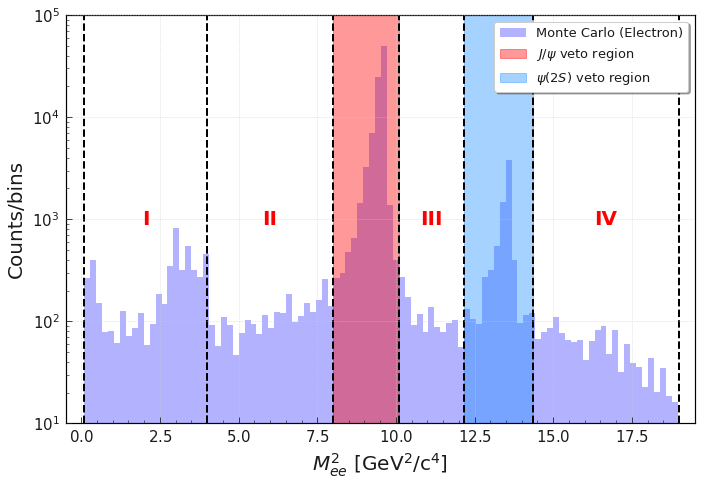

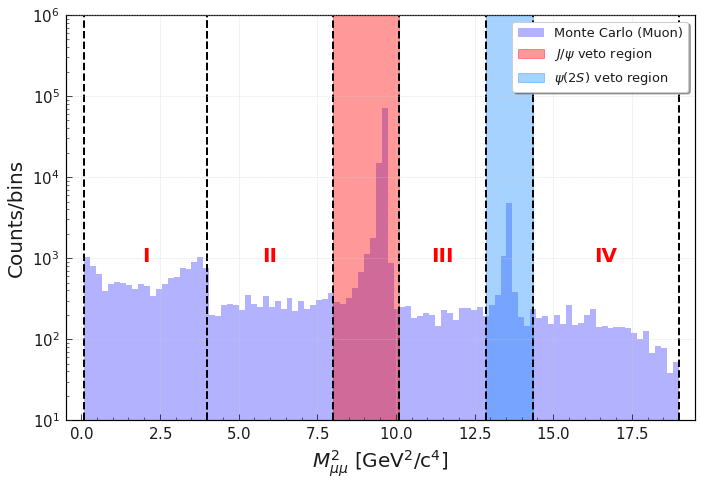

In [56]:
########## B0pip_with_Acceptance_weight #################

# Example usage for electron data, saving the plot as a PDF
plot_mc_data_with_veto_regions(
    data=mc_ele_B0pip['q2'], 
    weights=mc_ele_with_Acceptance_weight_B0pip, 
    x_label=r'$M^2_{ee} \ [\mathrm{GeV^2/c^4}]$', 
    title="Monte Carlo Data with Electron Ranges",
    particle_type='electron',  # Specify that the data is for electrons
    veto_regions=[
        (8.0, 10.087, 'red', r'$J/\psi$ veto region'),
        (12.152, 14.349, 'dodgerblue', r'$\psi(2S)$ veto region')
    ],
    filename="veto_B0pip_decay_ele_with_Acceptance_weight"
)

# Example usage for muon data, saving the plot as a PDF
plot_mc_data_with_veto_regions(
    data=mc_mu_B0pip['q2'], 
    weights=mc_mu_with_Acceptance_weight_B0pip, 
    x_label=r'$M^2_{\mu\mu} \ [\mathrm{GeV^2/c^4}]$', 
    title="Monte Carlo Data with Muon Ranges",
    particle_type='muon',  # Specify that the data is for muons
    veto_regions=[
        (8.0, 10.087, 'red', r'$J/\psi$ veto region'),
        (12.859, 14.349, 'dodgerblue', r'$\psi(2S)$ veto region')
    ],
    filename="veto_B0pip_decay_mu_with_Acceptance_weight"
)


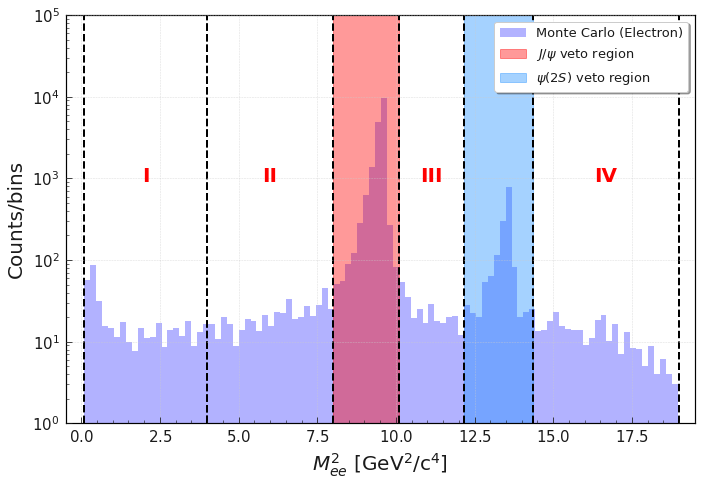

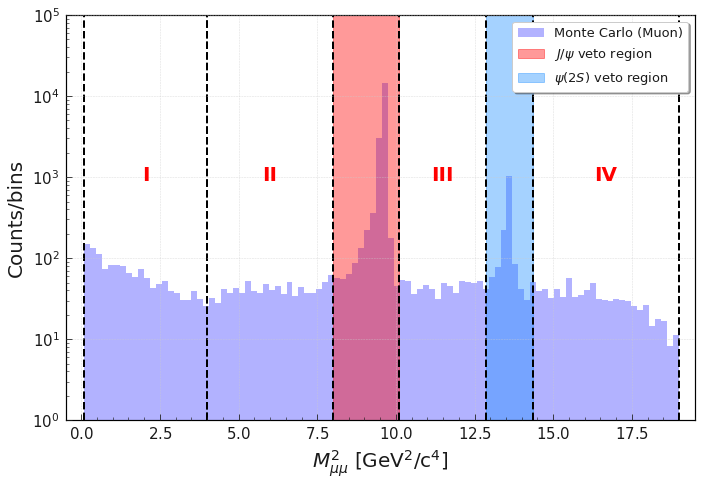

In [57]:
########## B0pip_without_Acceptance_weight #################

# Example usage for electron data, saving the plot as a PDF
plot_mc_data_with_veto_regions(
    data=mc_ele_B0pip['q2'], 
    weights=mc_ele_without_Acceptance_weight_B0pip, 
    x_label=r'$M^2_{ee} \ [\mathrm{GeV^2/c^4}]$', 
    title="Monte Carlo Data with Electron Ranges",
    particle_type='electron',  # Specify that the data is for electrons
    veto_regions=[
        (8.0, 10.087, 'red', r'$J/\psi$ veto region'),
        (12.152, 14.349, 'dodgerblue', r'$\psi(2S)$ veto region')
    ],
    filename="veto_B0pip_decay_ele_without_Acceptance_weight"
)

# Example usage for muon data, saving the plot as a PDF
plot_mc_data_with_veto_regions(
    data=mc_mu_B0pip['q2'], 
    weights=mc_mu_without_Acceptance_weight_B0pip, 
    x_label=r'$M^2_{\mu\mu} \ [\mathrm{GeV^2/c^4}]$', 
    title="Monte Carlo Data with Muon Ranges",
    particle_type='muon',  # Specify that the data is for muons
    veto_regions=[
        (8.0, 10.087, 'red', r'$J/\psi$ veto region'),
        (12.859, 14.349, 'dodgerblue', r'$\psi(2S)$ veto region')
    ],
    filename="veto_B0pip_decay_mu_without_Acceptance_weight"
)


## Bppip

In [58]:
#Bppip_with_Acceptance_weight
mc_ele_signal_Bppip,mc_ele_only_signal_Bppip,mc_ele_scf_Bppip,mc_ele_bkg_Bppip, mc_ele_signal_with_Acceptance_weight_Bppip,mc_ele_only_signal_with_Acceptance_weight_Bppip,mc_ele_scf_with_Acceptance_weight_Bppip,mc_ele_bkg_with_Acceptance_weight_Bppip = process_MC_data_combined(file_signal_ele_Bppip, file_bkg_ele_Bppip, 'ele', '521', 'pip', 'ee', 10, 'rec521','PIDCorrectionAndAcceptanceWeight')

mc_mu_signal_Bppip,mc_mu_only_signal_Bppip,mc_mu_scf_Bppip,mc_mu_bkg_Bppip, mc_mu_signal_with_Acceptance_weight_Bppip,mc_mu_only_signal_with_Acceptance_weight_Bppip,mc_mu_scf_with_Acceptance_weight_Bppip,mc_mu_bkg_with_Acceptance_weight_Bppip = process_MC_data_combined(file_signal_mu_Bppip, file_bkg_mu_Bppip, 'mu', '521', 'pip', 'mumu', 10, 'rec521','PIDCorrectionAndAcceptanceWeight')

mc_ele_Bppip = pd.concat([mc_ele_signal_Bppip, mc_ele_bkg_Bppip])
mc_ele_with_Acceptance_weight_Bppip = pd.concat([mc_ele_signal_with_Acceptance_weight_Bppip, mc_ele_bkg_with_Acceptance_weight_Bppip])

mc_mu_Bppip = pd.concat([mc_mu_signal_Bppip, mc_mu_bkg_Bppip])
mc_mu_with_Acceptance_weight_Bppip = pd.concat([mc_mu_signal_with_Acceptance_weight_Bppip, mc_mu_bkg_with_Acceptance_weight_Bppip])


#Bppip_without_Acceptance_weight
mc_ele_signal_Bppip,mc_ele_only_signal_Bppip,mc_ele_scf_Bppip,mc_ele_bkg_Bppip, mc_ele_signal_without_Acceptance_weight_Bppip,mc_ele_only_signal_without_Acceptance_weight_Bppip,mc_ele_scf_without_Acceptance_weight_Bppip,mc_ele_bkg_without_Acceptance_weight_Bppip = process_MC_data_combined(file_signal_ele_Bppip, file_bkg_ele_Bppip, 'ele', '521', 'pip', 'ee', 10, 'rec521','weights')

mc_mu_signal_Bppip,mc_mu_only_signal_Bppip,mc_mu_scf_Bppip,mc_mu_bkg_Bppip, mc_mu_signal_without_Acceptance_weight_Bppip,mc_mu_only_signal_without_Acceptance_weight_Bppip,mc_mu_scf_without_Acceptance_weight_Bppip,mc_mu_bkg_without_Acceptance_weight_Bppip = process_MC_data_combined(file_signal_mu_Bppip, file_bkg_mu_Bppip, 'mu', '521', 'pip', 'mumu', 10, 'rec521','weights')


mc_ele_without_Acceptance_weight_Bppip = pd.concat([mc_ele_signal_without_Acceptance_weight_Bppip, mc_ele_bkg_without_Acceptance_weight_Bppip])


mc_mu_without_Acceptance_weight_Bppip = pd.concat([mc_mu_signal_without_Acceptance_weight_Bppip, mc_mu_bkg_without_Acceptance_weight_Bppip])



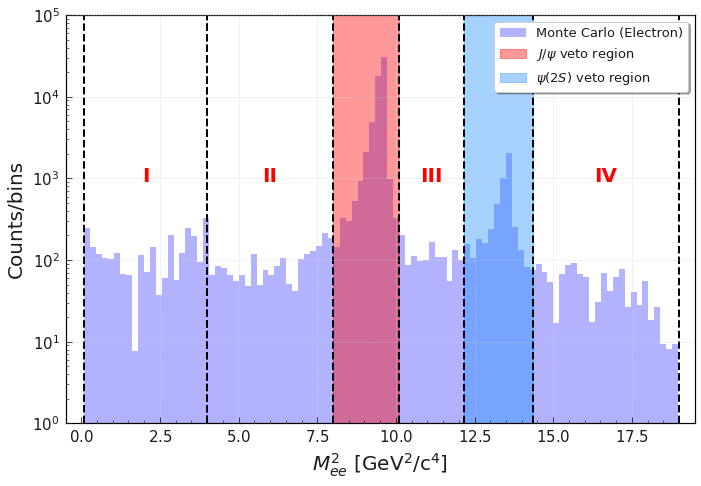

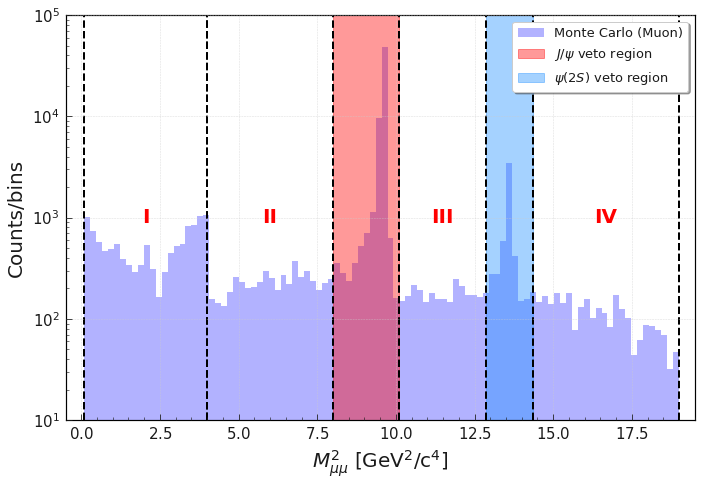

In [59]:
########## Bppip_with_Acceptance_weight #################

# Example usage for electron data, saving the plot as a PDF
plot_mc_data_with_veto_regions(
    data=mc_ele_Bppip['q2'], 
    weights=mc_ele_with_Acceptance_weight_Bppip, 
    x_label=r'$M^2_{ee} \ [\mathrm{GeV^2/c^4}]$', 
    title="Monte Carlo Data with Electron Ranges",
    particle_type='electron',  # Specify that the data is for electrons
    veto_regions=[
        (8.0, 10.087, 'red', r'$J/\psi$ veto region'),
        (12.152, 14.349, 'dodgerblue', r'$\psi(2S)$ veto region')
    ],
    filename="veto_Bppip_decay_ele_with_Acceptance_weight"
)

# Example usage for muon data, saving the plot as a PDF
plot_mc_data_with_veto_regions(
    data=mc_mu_Bppip['q2'], 
    weights=mc_mu_with_Acceptance_weight_Bppip, 
    x_label=r'$M^2_{\mu\mu} \ [\mathrm{GeV^2/c^4}]$', 
    title="Monte Carlo Data with Muon Ranges",
    particle_type='muon',  # Specify that the data is for muons
    veto_regions=[
        (8.0, 10.087, 'red', r'$J/\psi$ veto region'),
        (12.859, 14.349, 'dodgerblue', r'$\psi(2S)$ veto region')
    ],
    filename="veto_Bppip_decay_mu_with_Acceptance_weight"
)


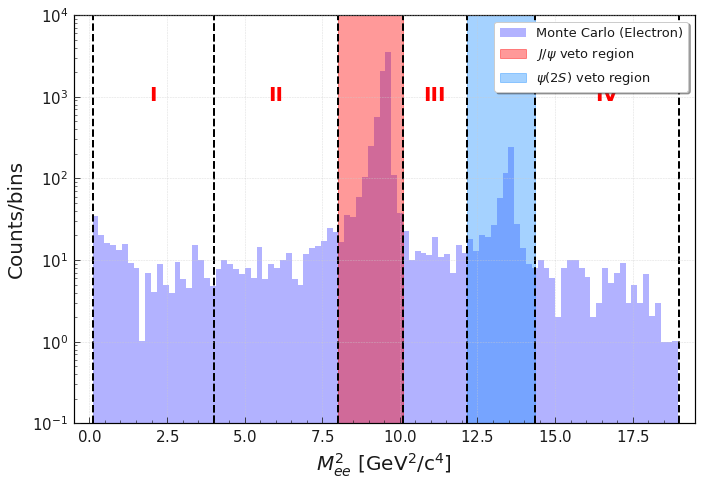

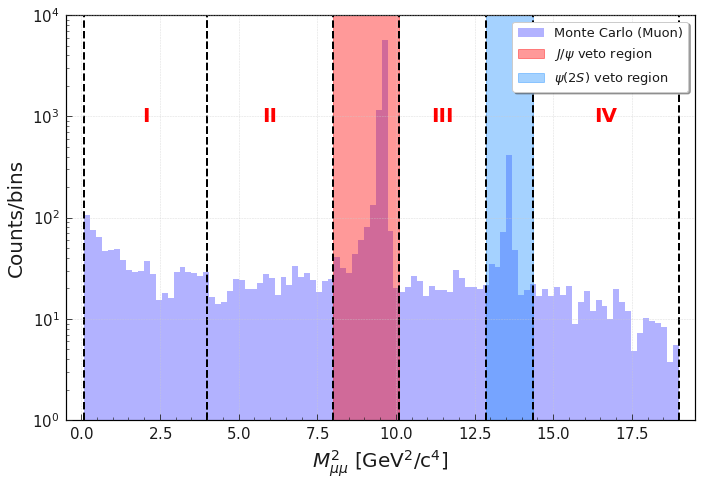

In [60]:
########## Bppip_without_Acceptance_weight #################

# Example usage for electron data, saving the plot as a PDF
plot_mc_data_with_veto_regions(
    data=mc_ele_Bppip['q2'], 
    weights=mc_ele_without_Acceptance_weight_Bppip, 
    x_label=r'$M^2_{ee} \ [\mathrm{GeV^2/c^4}]$', 
    title="Monte Carlo Data with Electron Ranges",
    particle_type='electron',  # Specify that the data is for electrons
    veto_regions=[
        (8.0, 10.087, 'red', r'$J/\psi$ veto region'),
        (12.152, 14.349, 'dodgerblue', r'$\psi(2S)$ veto region')
    ],
    filename="veto_Bppip_decay_ele_without_Acceptance_weight"
)

# Example usage for muon data, saving the plot as a PDF
plot_mc_data_with_veto_regions(
    data=mc_mu_Bppip['q2'], 
    weights=mc_mu_without_Acceptance_weight_Bppip, 
    x_label=r'$M^2_{\mu\mu} \ [\mathrm{GeV^2/c^4}]$', 
    title="Monte Carlo Data with Muon Ranges",
    particle_type='muon',  # Specify that the data is for muons
    veto_regions=[
        (8.0, 10.087, 'red', r'$J/\psi$ veto region'),
        (12.859, 14.349, 'dodgerblue', r'$\psi(2S)$ veto region')
    ],
    filename="veto_Bppip_decay_mu_without_Acceptance_weight"
)


## Bppi0

In [61]:
#Bppi0_with_Acceptance_weight
mc_ele_signal_Bppi0,mc_ele_only_signal_Bppi0,mc_ele_scf_Bppi0,mc_ele_bkg_Bppi0, mc_ele_signal_with_Acceptance_weight_Bppi0,mc_ele_only_signal_with_Acceptance_weight_Bppi0,mc_ele_scf_with_Acceptance_weight_Bppi0,mc_ele_bkg_with_Acceptance_weight_Bppi0 = process_MC_data_combined(file_signal_ele_Bppi0, file_bkg_ele_Bppi0, 'ele', '521', 'pi0', 'ee', 10, 'rec521','PIDCorrectionAndAcceptanceWeight')

mc_mu_signal_Bppi0,mc_mu_only_signal_Bppi0,mc_mu_scf_Bppi0,mc_mu_bkg_Bppi0, mc_mu_signal_with_Acceptance_weight_Bppi0,mc_mu_only_signal_with_Acceptance_weight_Bppi0,mc_mu_scf_with_Acceptance_weight_Bppi0,mc_mu_bkg_with_Acceptance_weight_Bppi0 = process_MC_data_combined(file_signal_mu_Bppi0, file_bkg_mu_Bppi0, 'mu', '521', 'pi0', 'mumu', 10, 'rec521','PIDCorrectionAndAcceptanceWeight')

mc_ele_Bppi0 = pd.concat([mc_ele_signal_Bppi0, mc_ele_bkg_Bppi0])
mc_ele_with_Acceptance_weight_Bppi0 = pd.concat([mc_ele_signal_with_Acceptance_weight_Bppi0, mc_ele_bkg_with_Acceptance_weight_Bppi0])

mc_mu_Bppi0 = pd.concat([mc_mu_signal_Bppi0, mc_mu_bkg_Bppi0])
mc_mu_with_Acceptance_weight_Bppi0 = pd.concat([mc_mu_signal_with_Acceptance_weight_Bppi0, mc_mu_bkg_with_Acceptance_weight_Bppi0])


#Bppi0_without_Acceptance_weight
mc_ele_signal_Bppi0,mc_ele_only_signal_Bppi0,mc_ele_scf_Bppi0,mc_ele_bkg_Bppi0, mc_ele_signal_without_Acceptance_weight_Bppi0,mc_ele_only_signal_without_Acceptance_weight_Bppi0,mc_ele_scf_without_Acceptance_weight_Bppi0,mc_ele_bkg_without_Acceptance_weight_Bppi0 = process_MC_data_combined(file_signal_ele_Bppi0, file_bkg_ele_Bppi0, 'ele', '521', 'pi0', 'ee', 10, 'rec521','weights')

mc_mu_signal_Bppi0,mc_mu_only_signal_Bppi0,mc_mu_scf_Bppi0,mc_mu_bkg_Bppi0, mc_mu_signal_without_Acceptance_weight_Bppi0,mc_mu_only_signal_without_Acceptance_weight_Bppi0,mc_mu_scf_without_Acceptance_weight_Bppi0,mc_mu_bkg_without_Acceptance_weight_Bppi0 = process_MC_data_combined(file_signal_mu_Bppi0, file_bkg_mu_Bppi0, 'mu', '521', 'pi0', 'mumu', 10, 'rec521','weights')

mc_ele_without_Acceptance_weight_Bppi0 = pd.concat([mc_ele_signal_without_Acceptance_weight_Bppi0, mc_ele_bkg_without_Acceptance_weight_Bppi0])

mc_mu_without_Acceptance_weight_Bppi0 = pd.concat([mc_mu_signal_without_Acceptance_weight_Bppi0, mc_mu_bkg_without_Acceptance_weight_Bppi0])


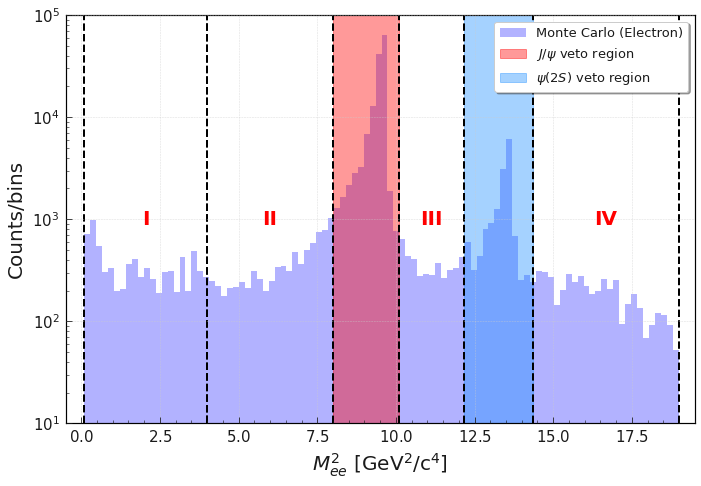

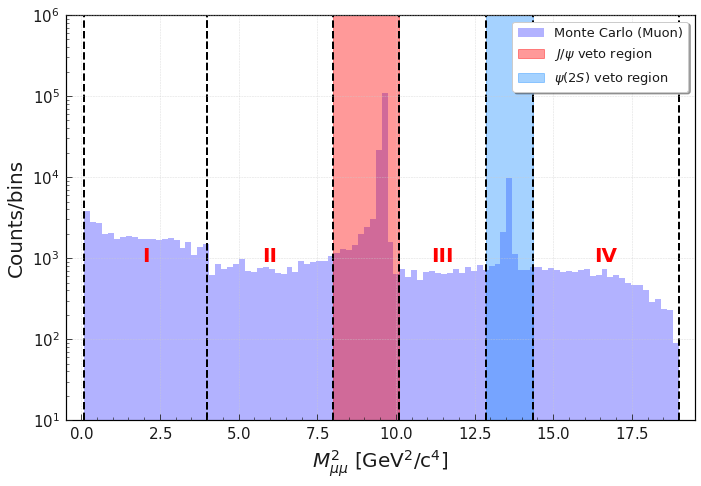

In [62]:
########## Bppi0_with_Acceptance_weight #################

# Example usage for electron data, saving the plot as a PDF
plot_mc_data_with_veto_regions(
    data=mc_ele_Bppi0['q2'], 
    weights=mc_ele_with_Acceptance_weight_Bppi0, 
    x_label=r'$M^2_{ee} \ [\mathrm{GeV^2/c^4}]$', 
    title="Monte Carlo Data with Electron Ranges",
    particle_type='electron',  # Specify that the data is for electrons
    veto_regions=[
        (8.0, 10.087, 'red', r'$J/\psi$ veto region'),
        (12.152, 14.349, 'dodgerblue', r'$\psi(2S)$ veto region')
    ],
    filename="veto_Bppi0_decay_ele_with_Acceptance_weight"
)

# Example usage for muon data, saving the plot as a PDF
plot_mc_data_with_veto_regions(
    data=mc_mu_Bppi0['q2'], 
    weights=mc_mu_with_Acceptance_weight_Bppi0, 
    x_label=r'$M^2_{\mu\mu} \ [\mathrm{GeV^2/c^4}]$', 
    title="Monte Carlo Data with Muon Ranges",
    particle_type='muon',  # Specify that the data is for muons
    veto_regions=[
        (8.0, 10.087, 'red', r'$J/\psi$ veto region'),
        (12.859, 14.349, 'dodgerblue', r'$\psi(2S)$ veto region')
    ],
    filename="veto_Bppi0_decay_mu_with_Acceptance_weight"
)


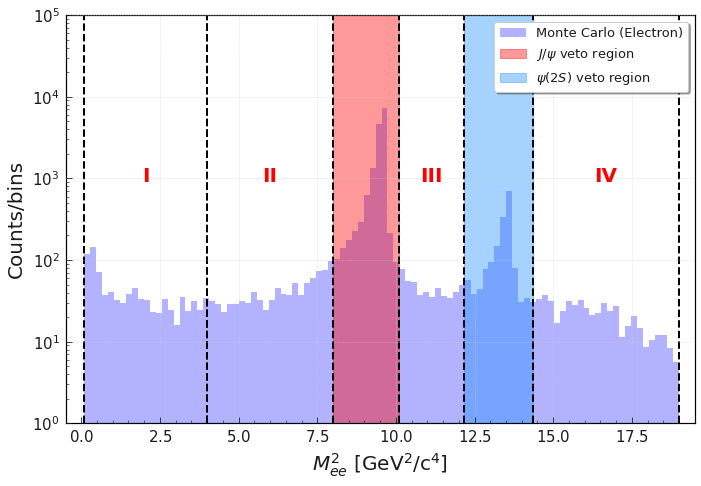

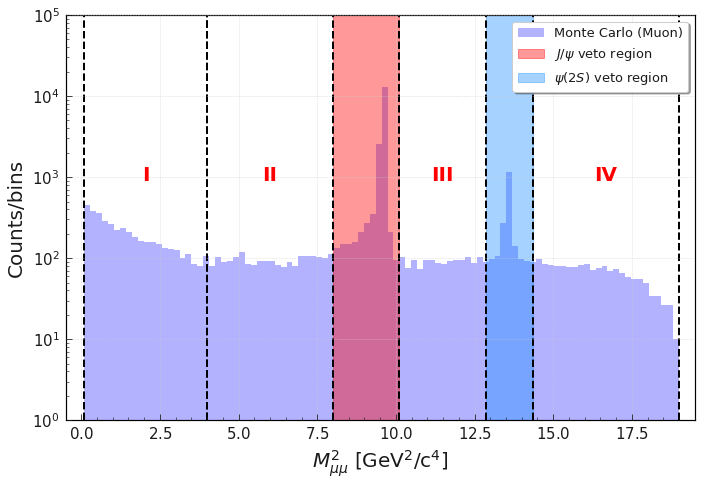

In [63]:
########## Bppip_without_Acceptance_weight #################

# Example usage for electron data, saving the plot as a PDF
plot_mc_data_with_veto_regions(
    data=mc_ele_Bppi0['q2'], 
    weights=mc_ele_without_Acceptance_weight_Bppi0, 
    x_label=r'$M^2_{ee} \ [\mathrm{GeV^2/c^4}]$', 
    title="Monte Carlo Data with Electron Ranges",
    particle_type='electron',  # Specify that the data is for electrons
    veto_regions=[
        (8.0, 10.087, 'red', r'$J/\psi$ veto region'),
        (12.152, 14.349, 'dodgerblue', r'$\psi(2S)$ veto region')
    ],
    filename="veto_Bppi0_decay_ele_without_Acceptance_weight"
)

# Example usage for muon data, saving the plot as a PDF
plot_mc_data_with_veto_regions(
    data=mc_mu_Bppi0['q2'], 
    weights=mc_mu_without_Acceptance_weight_Bppi0, 
    x_label=r'$M^2_{\mu\mu} \ [\mathrm{GeV^2/c^4}]$', 
    title="Monte Carlo Data with Muon Ranges",
    particle_type='muon',  # Specify that the data is for muons
    veto_regions=[
        (8.0, 10.087, 'red', r'$J/\psi$ veto region'),
        (12.859, 14.349, 'dodgerblue', r'$\psi(2S)$ veto region')
    ],
    filename="veto_Bppi0_decay_mu_without_Acceptance_weight"
)


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot correlation matrix for each q2reg
def plot_correlation(q2_data, Mbc_data, deltaE_data, file, q2reg, decay):
    data = {
        'q2': q2_data[q2reg],
        'Mbc': Mbc_data[q2reg],
        'deltaE': deltaE_data[q2reg]
    }
    df = pd.DataFrame(data)
    corr = df.corr()
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    #plt.title(f'Correlation matrix for {file}_{q2reg}_{decay}')
    plt.savefig(f'Correlation_matrix_for_{file}_{q2reg}_{decay}.pdf', format='pdf')
    plt.show()


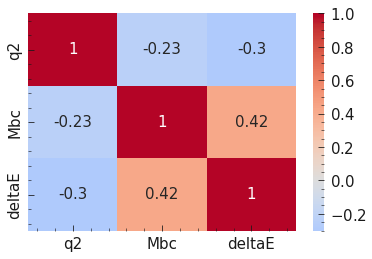

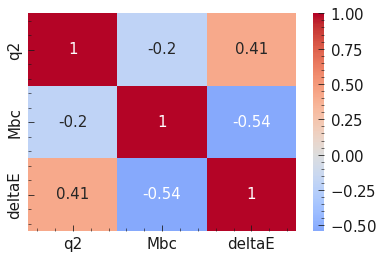

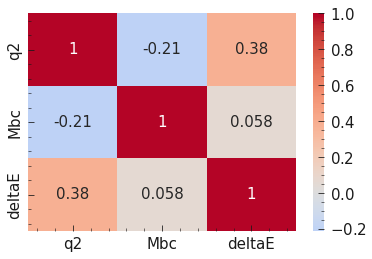

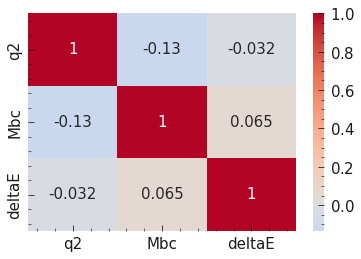

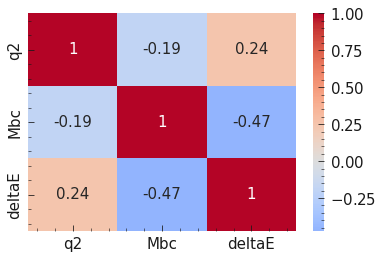

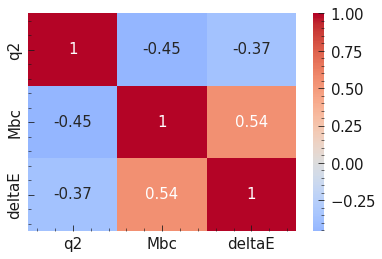

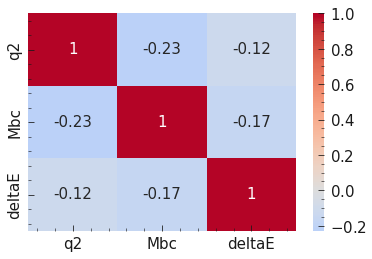

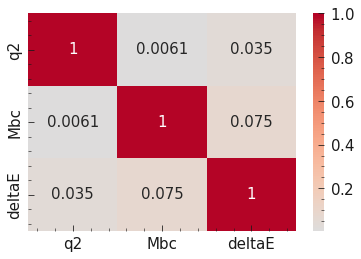

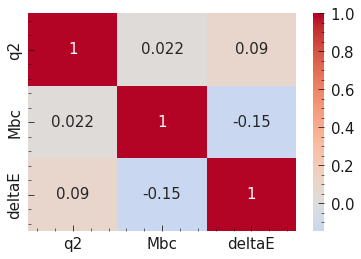

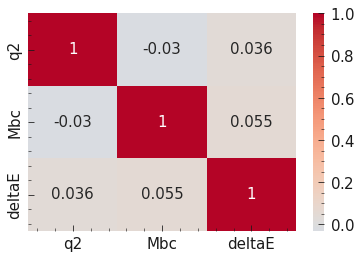

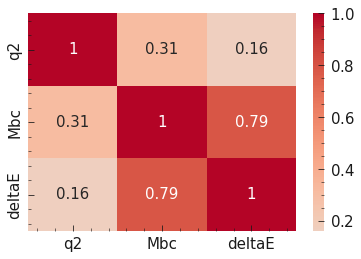

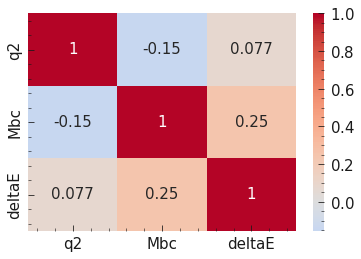

In [18]:
#electron

q2_1_mc_ele_signal,q2_1_mc_ele_only_signal,q2_1_mc_ele_scf,q2_1_mc_ele_bkg, q2_1_mc_ele_signal_weight,q2_1_mc_ele_only_signal_weight,q2_1_mc_ele_scf_weight,q2_1_mc_ele_bkg_weight =process_MC_data_combined(file_signal_ele_B0pip, file_bkg_ele_B0pip, 'ele', '511', 'pip', 'ee', 1, 'rec511','PIDCorrectionAndAcceptanceWeight')
q2_2_mc_ele_signal,q2_2_mc_ele_only_signal,q2_2_mc_ele_scf,q2_2_mc_ele_bkg,q2_2_mc_ele_signal_weight,q2_2_mc_ele_only_signal_weight,q2_2_mc_ele_scf_weight,q2_2_mc_ele_bkg_weight=process_MC_data_combined(file_signal_ele_B0pip, file_bkg_ele_B0pip, 'ele', '511', 'pip', 'ee', 2, 'rec511','PIDCorrectionAndAcceptanceWeight')
q2_3_mc_ele_signal,q2_3_mc_ele_only_signal,q2_3_mc_ele_scf,q2_3_mc_ele_bkg,q2_3_mc_ele_signal_weight,q2_3_mc_ele_only_signal_weight,q2_3_mc_ele_scf_weight,q2_3_mc_ele_bkg_weight =process_MC_data_combined(file_signal_ele_B0pip, file_bkg_ele_B0pip, 'ele', '511', 'pip', 'ee', 3, 'rec511','PIDCorrectionAndAcceptanceWeight')
q2_4_mc_ele_signal,q2_4_mc_ele_only_signal,q2_4_mc_ele_scf,q2_4_mc_ele_bkg,q2_4_mc_ele_signal_weight,q2_4_mc_ele_only_signal_weight,q2_4_mc_ele_scf_weight,q2_4_mc_ele_bkg_weight =process_MC_data_combined(file_signal_ele_B0pip, file_bkg_ele_B0pip, 'ele', '511', 'pip', 'ee', 4, 'rec511','PIDCorrectionAndAcceptanceWeight')
q2_11_mc_ele_signal,q2_11_mc_ele_only_signal,q2_11_mc_ele_scf,q2_11_mc_ele_bkg,q2_11_mc_ele_signal_weight,q2_11_mc_ele_only_signal_weight,q2_11_mc_ele_scf_weight,q2_11_mc_ele_bkg_weight =process_MC_data_combined(file_signal_ele_B0pip, file_bkg_ele_B0pip, 'ele', '511', 'pip', 'ee', 11, 'rec511','PIDCorrectionAndAcceptanceWeight')
q2_12_mc_ele_signal,q2_12_mc_ele_only_signal,q2_12_mc_ele_scf,q2_12_mc_ele_bkg,q2_12_mc_ele_signal_weight,q2_12_mc_ele_only_signal_weight,q2_12_mc_ele_scf_weight,q2_12_mc_ele_bkg_weight =process_MC_data_combined(file_signal_ele_B0pip, file_bkg_ele_B0pip, 'ele', '511', 'pip', 'ee', 12, 'rec511','PIDCorrectionAndAcceptanceWeight')


#muon
q2_1_mc_mu_signal,q2_1_mc_mu_only_signal,q2_1_mc_mu_scf,q2_1_mc_mu_bkg, q2_1_mc_mu_signal_weight,q2_1_mc_mu_only_signal_weight,q2_1_mc_mu_scf_weight,q2_1_mc_mu_bkg_weight =process_MC_data_combined(file_signal_mu_B0pip, file_bkg_mu_B0pip, 'mu', '511', 'pip', 'mumu', 1, 'rec511','PIDCorrectionAndAcceptanceWeight')
q2_2_mc_mu_signal,q2_2_mc_mu_only_signal,q2_2_mc_mu_scf,q2_2_mc_mu_bkg,q2_2_mc_mu_signal_weight,q2_2_mc_mu_only_signal_weight,q2_2_mc_mu_scf_weight,q2_2_mc_mu_bkg_weight=process_MC_data_combined(file_signal_mu_B0pip, file_bkg_mu_B0pip, 'mu', '511', 'pip', 'mumu', 2, 'rec511','PIDCorrectionAndAcceptanceWeight')
q2_3_mc_mu_signal,q2_3_mc_mu_only_signal,q2_3_mc_mu_scf,q2_3_mc_mu_bkg,q2_3_mc_mu_signal_weight,q2_3_mc_mu_only_signal_weight,q2_3_mc_mu_scf_weight,q2_3_mc_mu_bkg_weight =process_MC_data_combined(file_signal_mu_B0pip, file_bkg_mu_B0pip, 'mu', '511', 'pip', 'mumu', 3, 'rec511','PIDCorrectionAndAcceptanceWeight')
q2_4_mc_mu_signal,q2_4_mc_mu_only_signal,q2_4_mc_mu_scf,q2_4_mc_mu_bkg,q2_4_mc_mu_signal_weight,q2_4_mc_mu_only_signal_weight,q2_4_mc_mu_scf_weight,q2_4_mc_mu_bkg_weight =process_MC_data_combined(file_signal_mu_B0pip, file_bkg_mu_B0pip, 'mu', '511', 'pip', 'mumu', 4, 'rec511','PIDCorrectionAndAcceptanceWeight')
q2_11_mc_mu_signal,q2_11_mc_mu_only_signal,q2_11_mc_mu_scf,q2_11_mc_mu_bkg,q2_11_mc_mu_signal_weight,q2_11_mc_mu_only_signal_weight,q2_11_mc_mu_scf_weight,q2_11_mc_mu_bkg_weight =process_MC_data_combined(file_signal_mu_B0pip, file_bkg_mu_B0pip, 'mu', '511', 'pip', 'mumu', 11, 'rec511','PIDCorrectionAndAcceptanceWeight')
q2_12_mc_mu_signal,q2_12_mc_mu_only_signal,q2_12_mc_mu_scf,q2_12_mc_mu_bkg,q2_12_mc_mu_signal_weight,q2_12_mc_mu_only_signal_weight,q2_12_mc_mu_scf_weight,q2_12_mc_mu_bkg_weight =process_MC_data_combined(file_signal_mu_B0pip, file_bkg_mu_B0pip, 'mu', '511', 'pip', 'mumu', 12, 'rec511','PIDCorrectionAndAcceptanceWeight')


# Sample data generation
data_ele_q2 = {
    'q2reg_1': q2_1_mc_ele_signal['q2'],
    'q2reg_2': q2_2_mc_ele_signal['q2'],
    'q2reg_3': q2_3_mc_ele_signal['q2'],
    'q2reg_4': q2_4_mc_ele_signal['q2'],
    'q2reg_11': q2_11_mc_ele_signal['q2'],
    'q2reg_12': q2_12_mc_ele_signal['q2']
}
data_ele_Mbc = {
    'q2reg_1': q2_1_mc_ele_signal['Mbc'],
    'q2reg_2': q2_2_mc_ele_signal['Mbc'],
    'q2reg_3': q2_3_mc_ele_signal['Mbc'],
    'q2reg_4': q2_4_mc_ele_signal['Mbc'],
    'q2reg_11': q2_11_mc_ele_signal['Mbc'],
    'q2reg_12': q2_12_mc_ele_signal['Mbc']
}
data_ele_deltaE = {
    'q2reg_1': q2_1_mc_ele_signal['deltaE'],
    'q2reg_2': q2_2_mc_ele_signal['deltaE'],
    'q2reg_3': q2_3_mc_ele_signal['deltaE'],
    'q2reg_4': q2_4_mc_ele_signal['deltaE'],
    'q2reg_11': q2_11_mc_ele_signal['deltaE'],
    'q2reg_12': q2_12_mc_ele_signal['deltaE']
}



# Define file and decay variables
file = 'B0pip'  # or any other relevant file name
decay= 'ee'    # or any other relevant decay type

# Plot correlation matrices for each q2reg
for q2reg in data_ele_q2.keys():
    plot_correlation(data_ele_q2, data_ele_Mbc, data_ele_deltaE, file, q2reg, decay)



# Sample data generation
data_mu_q2 = {
    'q2reg_1': q2_1_mc_mu_signal['q2'],
    'q2reg_2': q2_2_mc_mu_signal['q2'],
    'q2reg_3': q2_3_mc_mu_signal['q2'],
    'q2reg_4': q2_4_mc_mu_signal['q2'],
    'q2reg_11': q2_11_mc_mu_signal['q2'],
    'q2reg_12': q2_12_mc_mu_signal['q2']
}
data_mu_Mbc = {
    'q2reg_1': q2_1_mc_mu_signal['Mbc'],
    'q2reg_2': q2_2_mc_mu_signal['Mbc'],
    'q2reg_3': q2_3_mc_mu_signal['Mbc'],
    'q2reg_4': q2_4_mc_mu_signal['Mbc'],
    'q2reg_11': q2_11_mc_mu_signal['Mbc'],
    'q2reg_12': q2_12_mc_mu_signal['Mbc']
}
data_mu_deltaE = {
    'q2reg_1': q2_1_mc_mu_signal['deltaE'],
    'q2reg_2': q2_2_mc_mu_signal['deltaE'],
    'q2reg_3': q2_3_mc_mu_signal['deltaE'],
    'q2reg_4': q2_4_mc_mu_signal['deltaE'],
    'q2reg_11': q2_11_mc_mu_signal['deltaE'],
    'q2reg_12': q2_12_mc_mu_signal['deltaE']
}

# Define file and decay variables
file = 'B0pip'  # or any other relevant file name
decay= 'mumu'    # or any other relevant decay type

# Plot correlation matrices for each q2reg
for q2reg in data_mu_q2.keys():
    plot_correlation(data_mu_q2, data_mu_Mbc, data_mu_deltaE, file, q2reg, decay)





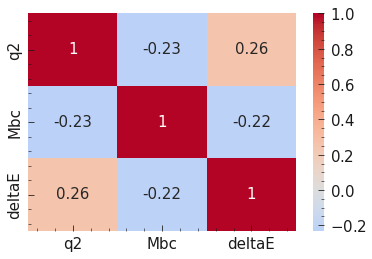

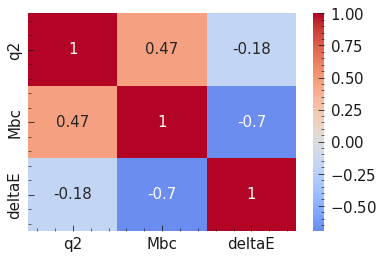

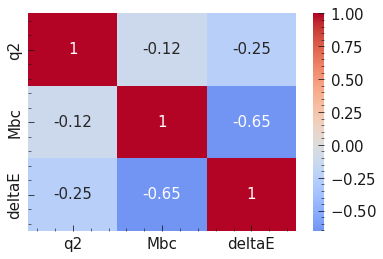

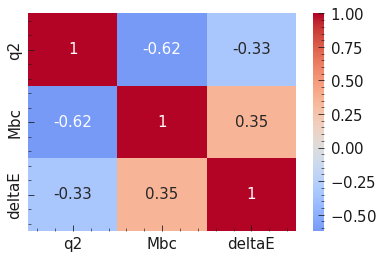

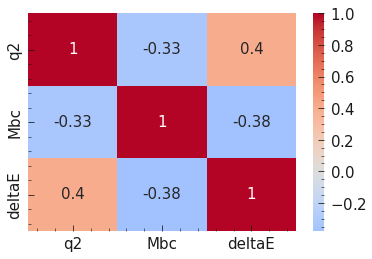

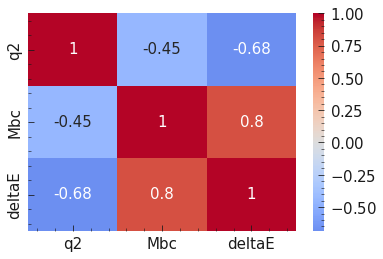

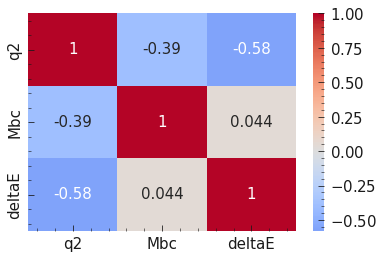

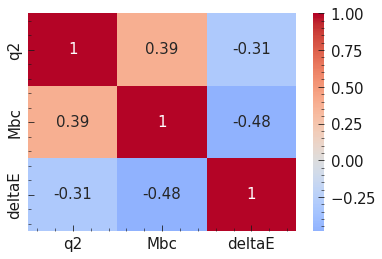

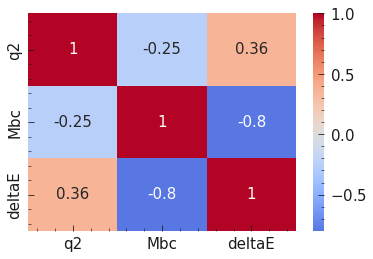

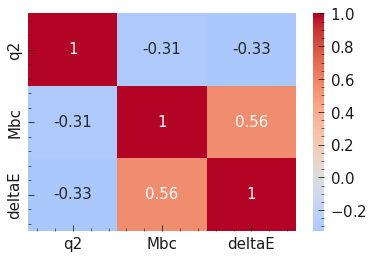

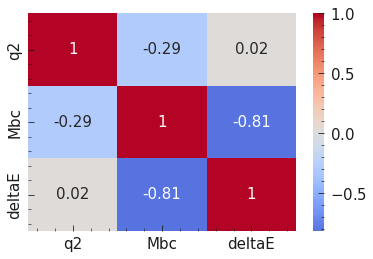

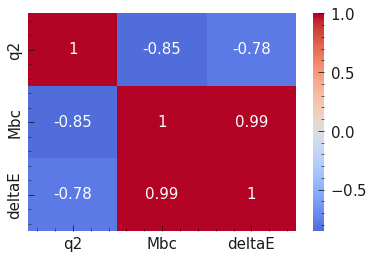

In [19]:
#electron

q2_1_mc_ele_signal,q2_1_mc_ele_only_signal,q2_1_mc_ele_scf,q2_1_mc_ele_bkg, q2_1_mc_ele_signal_weight,q2_1_mc_ele_only_signal_weight,q2_1_mc_ele_scf_weight,q2_1_mc_ele_bkg_weight =process_MC_data_combined(file_signal_ele_Bppip, file_bkg_ele_Bppip, 'ele', '521', 'pip', 'ee', 1, 'rec521','PIDCorrectionAndAcceptanceWeight')
q2_2_mc_ele_signal,q2_2_mc_ele_only_signal,q2_2_mc_ele_scf,q2_2_mc_ele_bkg,q2_2_mc_ele_signal_weight,q2_2_mc_ele_only_signal_weight,q2_2_mc_ele_scf_weight,q2_2_mc_ele_bkg_weight=process_MC_data_combined(file_signal_ele_Bppip, file_bkg_ele_Bppip, 'ele', '521', 'pip', 'ee', 2, 'rec521','PIDCorrectionAndAcceptanceWeight')
q2_3_mc_ele_signal,q2_3_mc_ele_only_signal,q2_3_mc_ele_scf,q2_3_mc_ele_bkg,q2_3_mc_ele_signal_weight,q2_3_mc_ele_only_signal_weight,q2_3_mc_ele_scf_weight,q2_3_mc_ele_bkg_weight =process_MC_data_combined(file_signal_ele_Bppip, file_bkg_ele_Bppip, 'ele', '521', 'pip', 'ee', 3, 'rec521','PIDCorrectionAndAcceptanceWeight')
q2_4_mc_ele_signal,q2_4_mc_ele_only_signal,q2_4_mc_ele_scf,q2_4_mc_ele_bkg,q2_4_mc_ele_signal_weight,q2_4_mc_ele_only_signal_weight,q2_4_mc_ele_scf_weight,q2_4_mc_ele_bkg_weight =process_MC_data_combined(file_signal_ele_Bppip, file_bkg_ele_Bppip, 'ele', '521', 'pip', 'ee', 4, 'rec521','PIDCorrectionAndAcceptanceWeight')
q2_11_mc_ele_signal,q2_11_mc_ele_only_signal,q2_11_mc_ele_scf,q2_11_mc_ele_bkg,q2_11_mc_ele_signal_weight,q2_11_mc_ele_only_signal_weight,q2_11_mc_ele_scf_weight,q2_11_mc_ele_bkg_weight =process_MC_data_combined(file_signal_ele_Bppip, file_bkg_ele_Bppip, 'ele', '521', 'pip', 'ee', 11, 'rec521','PIDCorrectionAndAcceptanceWeight')
q2_12_mc_ele_signal,q2_12_mc_ele_only_signal,q2_12_mc_ele_scf,q2_12_mc_ele_bkg,q2_12_mc_ele_signal_weight,q2_12_mc_ele_only_signal_weight,q2_12_mc_ele_scf_weight,q2_12_mc_ele_bkg_weight =process_MC_data_combined(file_signal_ele_Bppip, file_bkg_ele_Bppip, 'ele', '521', 'pip', 'ee', 12, 'rec521','PIDCorrectionAndAcceptanceWeight')


#muon
q2_1_mc_mu_signal,q2_1_mc_mu_only_signal,q2_1_mc_mu_scf,q2_1_mc_mu_bkg, q2_1_mc_mu_signal_weight,q2_1_mc_mu_only_signal_weight,q2_1_mc_mu_scf_weight,q2_1_mc_mu_bkg_weight =process_MC_data_combined(file_signal_mu_Bppip, file_bkg_mu_Bppip, 'mu', '521', 'pip', 'mumu', 1, 'rec521','PIDCorrectionAndAcceptanceWeight')
q2_2_mc_mu_signal,q2_2_mc_mu_only_signal,q2_2_mc_mu_scf,q2_2_mc_mu_bkg,q2_2_mc_mu_signal_weight,q2_2_mc_mu_only_signal_weight,q2_2_mc_mu_scf_weight,q2_2_mc_mu_bkg_weight=process_MC_data_combined(file_signal_mu_Bppip, file_bkg_mu_Bppip, 'mu', '521', 'pip', 'mumu', 2, 'rec521','PIDCorrectionAndAcceptanceWeight')
q2_3_mc_mu_signal,q2_3_mc_mu_only_signal,q2_3_mc_mu_scf,q2_3_mc_mu_bkg,q2_3_mc_mu_signal_weight,q2_3_mc_mu_only_signal_weight,q2_3_mc_mu_scf_weight,q2_3_mc_mu_bkg_weight =process_MC_data_combined(file_signal_mu_Bppip, file_bkg_mu_Bppip, 'mu', '521', 'pip', 'mumu', 3, 'rec521','PIDCorrectionAndAcceptanceWeight')
q2_4_mc_mu_signal,q2_4_mc_mu_only_signal,q2_4_mc_mu_scf,q2_4_mc_mu_bkg,q2_4_mc_mu_signal_weight,q2_4_mc_mu_only_signal_weight,q2_4_mc_mu_scf_weight,q2_4_mc_mu_bkg_weight =process_MC_data_combined(file_signal_mu_Bppip, file_bkg_mu_Bppip, 'mu', '521', 'pip', 'mumu', 4, 'rec521','PIDCorrectionAndAcceptanceWeight')
q2_11_mc_mu_signal,q2_11_mc_mu_only_signal,q2_11_mc_mu_scf,q2_11_mc_mu_bkg,q2_11_mc_mu_signal_weight,q2_11_mc_mu_only_signal_weight,q2_11_mc_mu_scf_weight,q2_11_mc_mu_bkg_weight =process_MC_data_combined(file_signal_mu_Bppip, file_bkg_mu_Bppip, 'mu', '521', 'pip', 'mumu', 11, 'rec521','PIDCorrectionAndAcceptanceWeight')
q2_12_mc_mu_signal,q2_12_mc_mu_only_signal,q2_12_mc_mu_scf,q2_12_mc_mu_bkg,q2_12_mc_mu_signal_weight,q2_12_mc_mu_only_signal_weight,q2_12_mc_mu_scf_weight,q2_12_mc_mu_bkg_weight =process_MC_data_combined(file_signal_mu_Bppip, file_bkg_mu_Bppip, 'mu', '521', 'pip', 'mumu', 12, 'rec521','PIDCorrectionAndAcceptanceWeight')

# Sample data generation
data_ele_q2 = {
    'q2reg_1': q2_1_mc_ele_signal['q2'],
    'q2reg_2': q2_2_mc_ele_signal['q2'],
    'q2reg_3': q2_3_mc_ele_signal['q2'],
    'q2reg_4': q2_4_mc_ele_signal['q2'],
    'q2reg_11': q2_11_mc_ele_signal['q2'],
    'q2reg_12': q2_12_mc_ele_signal['q2']
}
data_ele_Mbc = {
    'q2reg_1': q2_1_mc_ele_signal['Mbc'],
    'q2reg_2': q2_2_mc_ele_signal['Mbc'],
    'q2reg_3': q2_3_mc_ele_signal['Mbc'],
    'q2reg_4': q2_4_mc_ele_signal['Mbc'],
    'q2reg_11': q2_11_mc_ele_signal['Mbc'],
    'q2reg_12': q2_12_mc_ele_signal['Mbc']
}
data_ele_deltaE = {
    'q2reg_1': q2_1_mc_ele_signal['deltaE'],
    'q2reg_2': q2_2_mc_ele_signal['deltaE'],
    'q2reg_3': q2_3_mc_ele_signal['deltaE'],
    'q2reg_4': q2_4_mc_ele_signal['deltaE'],
    'q2reg_11': q2_11_mc_ele_signal['deltaE'],
    'q2reg_12': q2_12_mc_ele_signal['deltaE']
}



# Define file and decay variables
file = 'Bppip'  # or any other relevant file name
decay= 'ee'    # or any other relevant decay type

# Plot correlation matrices for each q2reg
for q2reg in data_ele_q2.keys():
    plot_correlation(data_ele_q2, data_ele_Mbc, data_ele_deltaE, file, q2reg, decay)



# Sample data generation
data_mu_q2 = {
    'q2reg_1': q2_1_mc_mu_signal['q2'],
    'q2reg_2': q2_2_mc_mu_signal['q2'],
    'q2reg_3': q2_3_mc_mu_signal['q2'],
    'q2reg_4': q2_4_mc_mu_signal['q2'],
    'q2reg_11': q2_11_mc_mu_signal['q2'],
    'q2reg_12': q2_12_mc_mu_signal['q2']
}
data_mu_Mbc = {
    'q2reg_1': q2_1_mc_mu_signal['Mbc'],
    'q2reg_2': q2_2_mc_mu_signal['Mbc'],
    'q2reg_3': q2_3_mc_mu_signal['Mbc'],
    'q2reg_4': q2_4_mc_mu_signal['Mbc'],
    'q2reg_11': q2_11_mc_mu_signal['Mbc'],
    'q2reg_12': q2_12_mc_mu_signal['Mbc']
}
data_mu_deltaE = {
    'q2reg_1': q2_1_mc_mu_signal['deltaE'],
    'q2reg_2': q2_2_mc_mu_signal['deltaE'],
    'q2reg_3': q2_3_mc_mu_signal['deltaE'],
    'q2reg_4': q2_4_mc_mu_signal['deltaE'],
    'q2reg_11': q2_11_mc_mu_signal['deltaE'],
    'q2reg_12': q2_12_mc_mu_signal['deltaE']
}

# Define file and decay variables
file = 'Bppip'  # or any other relevant file name
decay= 'mumu'    # or any other relevant decay type

# Plot correlation matrices for each q2reg
for q2reg in data_mu_q2.keys():
    plot_correlation(data_mu_q2, data_mu_Mbc, data_mu_deltaE, file, q2reg, decay)




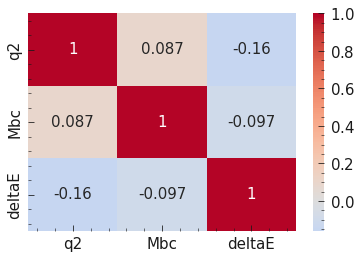

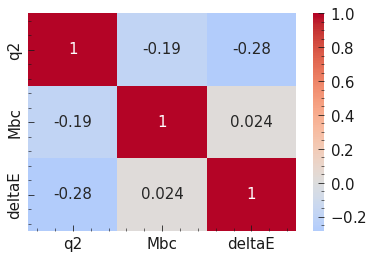

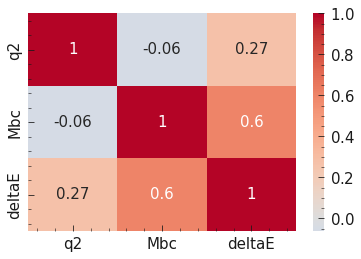

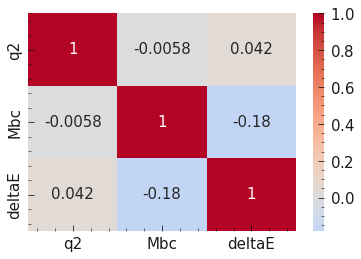

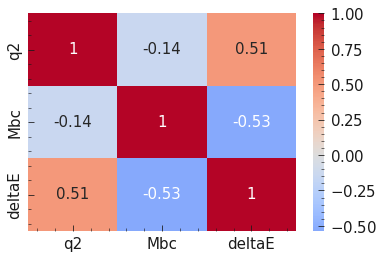

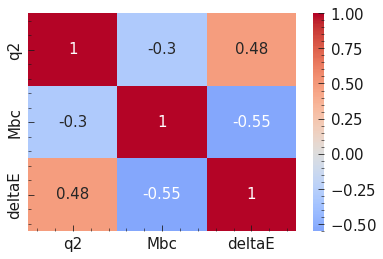

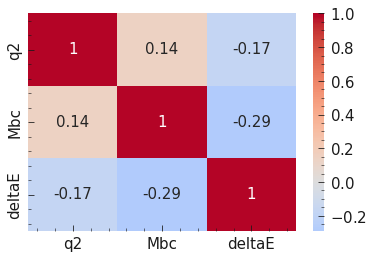

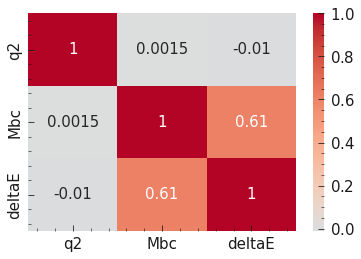

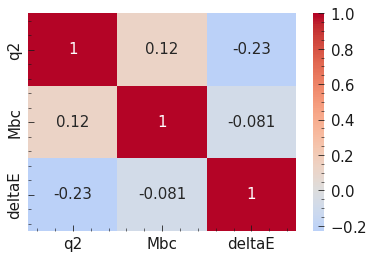

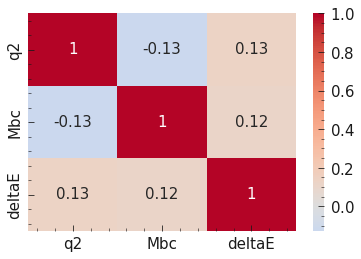

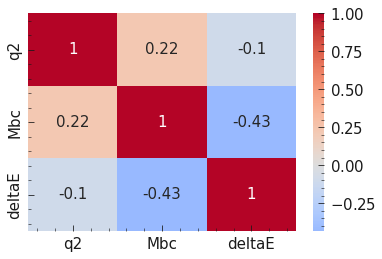

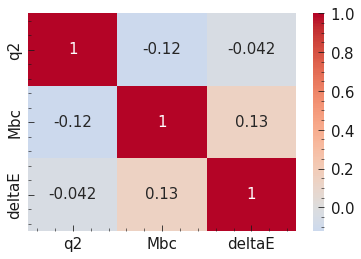

In [20]:
#electron

q2_1_mc_ele_signal,q2_1_mc_ele_only_signal,q2_1_mc_ele_scf,q2_1_mc_ele_bkg, q2_1_mc_ele_signal_weight,q2_1_mc_ele_only_signal_weight,q2_1_mc_ele_scf_weight,q2_1_mc_ele_bkg_weight =process_MC_data_combined(file_signal_ele_Bppi0, file_bkg_ele_Bppi0, 'ele', '521', 'pip', 'ee', 1, 'rec521','PIDCorrectionAndAcceptanceWeight')
q2_2_mc_ele_signal,q2_2_mc_ele_only_signal,q2_2_mc_ele_scf,q2_2_mc_ele_bkg,q2_2_mc_ele_signal_weight,q2_2_mc_ele_only_signal_weight,q2_2_mc_ele_scf_weight,q2_2_mc_ele_bkg_weight=process_MC_data_combined(file_signal_ele_Bppi0, file_bkg_ele_Bppi0, 'ele', '521', 'pip', 'ee', 2, 'rec521','PIDCorrectionAndAcceptanceWeight')
q2_3_mc_ele_signal,q2_3_mc_ele_only_signal,q2_3_mc_ele_scf,q2_3_mc_ele_bkg,q2_3_mc_ele_signal_weight,q2_3_mc_ele_only_signal_weight,q2_3_mc_ele_scf_weight,q2_3_mc_ele_bkg_weight =process_MC_data_combined(file_signal_ele_Bppi0, file_bkg_ele_Bppi0, 'ele', '521', 'pip', 'ee', 3, 'rec521','PIDCorrectionAndAcceptanceWeight')
q2_4_mc_ele_signal,q2_4_mc_ele_only_signal,q2_4_mc_ele_scf,q2_4_mc_ele_bkg,q2_4_mc_ele_signal_weight,q2_4_mc_ele_only_signal_weight,q2_4_mc_ele_scf_weight,q2_4_mc_ele_bkg_weight =process_MC_data_combined(file_signal_ele_Bppi0, file_bkg_ele_Bppi0, 'ele', '521', 'pip', 'ee', 4, 'rec521','PIDCorrectionAndAcceptanceWeight')
q2_11_mc_ele_signal,q2_11_mc_ele_only_signal,q2_11_mc_ele_scf,q2_11_mc_ele_bkg,q2_11_mc_ele_signal_weight,q2_11_mc_ele_only_signal_weight,q2_11_mc_ele_scf_weight,q2_11_mc_ele_bkg_weight =process_MC_data_combined(file_signal_ele_Bppi0, file_bkg_ele_Bppi0, 'ele', '521', 'pip', 'ee', 11, 'rec521','PIDCorrectionAndAcceptanceWeight')
q2_12_mc_ele_signal,q2_12_mc_ele_only_signal,q2_12_mc_ele_scf,q2_12_mc_ele_bkg,q2_12_mc_ele_signal_weight,q2_12_mc_ele_only_signal_weight,q2_12_mc_ele_scf_weight,q2_12_mc_ele_bkg_weight =process_MC_data_combined(file_signal_ele_Bppi0, file_bkg_ele_Bppi0, 'ele', '521', 'pip', 'ee', 12, 'rec521','PIDCorrectionAndAcceptanceWeight')


#muon
q2_1_mc_mu_signal,q2_1_mc_mu_only_signal,q2_1_mc_mu_scf,q2_1_mc_mu_bkg, q2_1_mc_mu_signal_weight,q2_1_mc_mu_only_signal_weight,q2_1_mc_mu_scf_weight,q2_1_mc_mu_bkg_weight =process_MC_data_combined(file_signal_mu_Bppi0, file_bkg_mu_Bppi0, 'mu', '521', 'pip', 'mumu', 1, 'rec521','PIDCorrectionAndAcceptanceWeight')
q2_2_mc_mu_signal,q2_2_mc_mu_only_signal,q2_2_mc_mu_scf,q2_2_mc_mu_bkg,q2_2_mc_mu_signal_weight,q2_2_mc_mu_only_signal_weight,q2_2_mc_mu_scf_weight,q2_2_mc_mu_bkg_weight=process_MC_data_combined(file_signal_mu_Bppi0, file_bkg_mu_Bppi0, 'mu', '521', 'pip', 'mumu', 2, 'rec521','PIDCorrectionAndAcceptanceWeight')
q2_3_mc_mu_signal,q2_3_mc_mu_only_signal,q2_3_mc_mu_scf,q2_3_mc_mu_bkg,q2_3_mc_mu_signal_weight,q2_3_mc_mu_only_signal_weight,q2_3_mc_mu_scf_weight,q2_3_mc_mu_bkg_weight =process_MC_data_combined(file_signal_mu_Bppi0, file_bkg_mu_Bppi0, 'mu', '521', 'pip', 'mumu', 3, 'rec521','PIDCorrectionAndAcceptanceWeight')
q2_4_mc_mu_signal,q2_4_mc_mu_only_signal,q2_4_mc_mu_scf,q2_4_mc_mu_bkg,q2_4_mc_mu_signal_weight,q2_4_mc_mu_only_signal_weight,q2_4_mc_mu_scf_weight,q2_4_mc_mu_bkg_weight =process_MC_data_combined(file_signal_mu_Bppi0, file_bkg_mu_Bppi0, 'mu', '521', 'pip', 'mumu', 4, 'rec521','PIDCorrectionAndAcceptanceWeight')
q2_11_mc_mu_signal,q2_11_mc_mu_only_signal,q2_11_mc_mu_scf,q2_11_mc_mu_bkg,q2_11_mc_mu_signal_weight,q2_11_mc_mu_only_signal_weight,q2_11_mc_mu_scf_weight,q2_11_mc_mu_bkg_weight =process_MC_data_combined(file_signal_mu_Bppi0, file_bkg_mu_Bppi0, 'mu', '521', 'pip', 'mumu', 11, 'rec521','PIDCorrectionAndAcceptanceWeight')
q2_12_mc_mu_signal,q2_12_mc_mu_only_signal,q2_12_mc_mu_scf,q2_12_mc_mu_bkg,q2_12_mc_mu_signal_weight,q2_12_mc_mu_only_signal_weight,q2_12_mc_mu_scf_weight,q2_12_mc_mu_bkg_weight =process_MC_data_combined(file_signal_mu_Bppi0, file_bkg_mu_Bppi0, 'mu', '521', 'pip', 'mumu', 12, 'rec521','PIDCorrectionAndAcceptanceWeight')

# Sample data generation
data_ele_q2 = {
    'q2reg_1': q2_1_mc_ele_signal['q2'],
    'q2reg_2': q2_2_mc_ele_signal['q2'],
    'q2reg_3': q2_3_mc_ele_signal['q2'],
    'q2reg_4': q2_4_mc_ele_signal['q2'],
    'q2reg_11': q2_11_mc_ele_signal['q2'],
    'q2reg_12': q2_12_mc_ele_signal['q2']
}
data_ele_Mbc = {
    'q2reg_1': q2_1_mc_ele_signal['Mbc'],
    'q2reg_2': q2_2_mc_ele_signal['Mbc'],
    'q2reg_3': q2_3_mc_ele_signal['Mbc'],
    'q2reg_4': q2_4_mc_ele_signal['Mbc'],
    'q2reg_11': q2_11_mc_ele_signal['Mbc'],
    'q2reg_12': q2_12_mc_ele_signal['Mbc']
}
data_ele_deltaE = {
    'q2reg_1': q2_1_mc_ele_signal['deltaE'],
    'q2reg_2': q2_2_mc_ele_signal['deltaE'],
    'q2reg_3': q2_3_mc_ele_signal['deltaE'],
    'q2reg_4': q2_4_mc_ele_signal['deltaE'],
    'q2reg_11': q2_11_mc_ele_signal['deltaE'],
    'q2reg_12': q2_12_mc_ele_signal['deltaE']
}



# Define file and decay variables
file = 'Bppi0'  # or any other relevant file name
decay= 'ee'    # or any other relevant decay type

# Plot correlation matrices for each q2reg
for q2reg in data_ele_q2.keys():
    plot_correlation(data_ele_q2, data_ele_Mbc, data_ele_deltaE, file, q2reg, decay)



# Sample data generation
data_mu_q2 = {
    'q2reg_1': q2_1_mc_mu_signal['q2'],
    'q2reg_2': q2_2_mc_mu_signal['q2'],
    'q2reg_3': q2_3_mc_mu_signal['q2'],
    'q2reg_4': q2_4_mc_mu_signal['q2'],
    'q2reg_11': q2_11_mc_mu_signal['q2'],
    'q2reg_12': q2_12_mc_mu_signal['q2']
}
data_mu_Mbc = {
    'q2reg_1': q2_1_mc_mu_signal['Mbc'],
    'q2reg_2': q2_2_mc_mu_signal['Mbc'],
    'q2reg_3': q2_3_mc_mu_signal['Mbc'],
    'q2reg_4': q2_4_mc_mu_signal['Mbc'],
    'q2reg_11': q2_11_mc_mu_signal['Mbc'],
    'q2reg_12': q2_12_mc_mu_signal['Mbc']
}
data_mu_deltaE = {
    'q2reg_1': q2_1_mc_mu_signal['deltaE'],
    'q2reg_2': q2_2_mc_mu_signal['deltaE'],
    'q2reg_3': q2_3_mc_mu_signal['deltaE'],
    'q2reg_4': q2_4_mc_mu_signal['deltaE'],
    'q2reg_11': q2_11_mc_mu_signal['deltaE'],
    'q2reg_12': q2_12_mc_mu_signal['deltaE']
}

# Define file and decay variables
file = 'Bppi0'  # or any other relevant file name
decay= 'mumu'    # or any other relevant decay type

# Plot correlation matrices for each q2reg
for q2reg in data_mu_q2.keys():
    plot_correlation(data_mu_q2, data_mu_Mbc, data_mu_deltaE, file, q2reg, decay)




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot correlation matrix for each q2reg
def plot_correlation(q2_data, Mbc_data, deltaE_data, file, q2reg, decay):
    # Creating a DataFrame with the provided data
    data = {
        'q2': q2_data[q2reg],
        'Mbc': Mbc_data[q2reg],
        'deltaE': deltaE_data[q2reg]
    }
    df = pd.DataFrame(data)
    
    # Calculating the correlation matrix
    corr = df.corr()

    # Setting up the figure size and style
    plt.figure(figsize=(8, 6))  # Larger figure size for better readability
    sns.set(style="whitegrid")  # Set a seaborn style for better aesthetics

    # Creating a heatmap with improved aesthetics
    heatmap = sns.heatmap(
        corr,
        annot=True,               # Show correlation values on the heatmap
        fmt=".2f",                # Limit the number of decimal places for clarity
        cmap='coolwarm',          # Diverging colormap to show positive and negative correlations
        center=0,                 # Center the colormap at zero
        linewidths=0.5,           # Add a slight border between cells
        linecolor='white',        # White lines for a cleaner look
        square=True,              # Make cells square-shaped for consistency
        cbar_kws={"shrink": 0.8}  # Adjust color bar size
    )

    # Adding a title with custom formatting for better presentation
    #plt.title(f'Correlation Matrix for {file}_{q2reg}_{decay}', fontsize=14, fontweight='bold', pad=16)

    # Improving layout by adjusting labels
    plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for readability
    plt.yticks(fontsize=12)                           # Increase font size for y-axis labels
    
    # Saving the plot as a PDF with better resolution
    plt.savefig(f'Correlation_matrix_for_{file}_{q2reg}_{decay}.pdf', format='pdf', dpi=300, bbox_inches='tight')

    # Display the plot
    plt.show()
